# Data Augmentation With Geometric Transformations

### Learning Objectives

You will learn how to apply data augmentation in two ways:

* Use Preprocessors.

* Transfer learning with MobileNet.

## Introduction

In this notebook, you learn how to carry out data augmentation to improve the model's resilience and accuracy. Data augmentation can be effectively used to train the deep learning models. Some of the simple transformations applied to the image are; geometric transformations such as Flipping, Rotation, Translation, Cropping and Scaling.

Each learning objective will correspond to a __#TODO__ in the [student lab notebook](../labs/data_augmentation_with_geometric_transformations.ipynb) -- try to complete that notebook first before reviewing this solution notebook.

In [1]:
# Import and print the installed version of TensorFlow
import tensorflow as tf
print(tf.version.VERSION)

2.6.0


## Preprocessor

This class contains preprocessing functions that have to be explicitly applied between training and prediction.

In [2]:
# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

In [3]:
# The import statement combines two operations; it searches for the named module, then it binds the results of that search
# to a name in the local scope.
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

IMG_HEIGHT = 448 # note *twice* what we used to have
IMG_WIDTH = 448
IMG_CHANNELS = 3
CLASS_NAMES = 'daisy dandelion roses sunflowers tulips'.split()

class _Preprocessor:    
    def __init__(self):
        # nothing to initialize
        pass
    
    def read_from_tfr(self, proto):
        feature_description = {
            'image': tf.io.VarLenFeature(tf.float32),
            'shape': tf.io.VarLenFeature(tf.int64),
            'label': tf.io.FixedLenFeature([], tf.string, default_value=''),
            'label_int': tf.io.FixedLenFeature([], tf.int64, default_value=0),
        }
        rec = tf.io.parse_single_example(
            proto, feature_description
        )
        shape = tf.sparse.to_dense(rec['shape'])
        img = tf.reshape(tf.sparse.to_dense(rec['image']), shape)
        label_int = rec['label_int']
        return img, label_int
    
    def read_from_jpegfile(self, filename):
        # same code as in 05_create_dataset/jpeg_to_tfrecord.py
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img
      
    def preprocess(self, img):
        #TODO 1: Resize and pad the image to a target width and height.
        return tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH)
    
def create_preproc_dataset(pattern):
    preproc = _Preprocessor()
    trainds = tf.data.TFRecordDataset(
        [filename for filename in tf.io.gfile.glob(pattern)],
        compression_type='GZIP'
    ).map(preproc.read_from_tfr).map(
        lambda img, label: (preproc.preprocess(img), label))                             
    return trainds

def create_preproc_image(filename):
    preproc = _Preprocessor()
    img = preproc.read_from_jpegfile(filename)
    return preproc.preprocess(img)    

## Transfer Learning with MobileNet

You use MobileNet model as your base model to train with your dataset and classify the images with random cropping & left-right flipping.

In [4]:
import tensorflow_hub as hub
import os
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'    

#PATTERN_SUFFIX='-0000*'
#NUM_EPOCHS=3

PATTERN_SUFFIX='-*'
NUM_EPOCHS=20

# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32,
                       lrate = 0.001,
                       l1 = 0.,
                       l2 = 0.,
                       num_hidden = 16):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)
    
    train_dataset = create_preproc_dataset(
        'gs://practical-ml-vision-book/flowers_tfr/train' + PATTERN_SUFFIX
    ).batch(batch_size)
    eval_dataset = create_preproc_dataset(
        'gs://practical-ml-vision-book/flowers_tfr/valid' + PATTERN_SUFFIX
    ).batch(batch_size)

    layers = [
      tf.keras.layers.experimental.preprocessing.RandomCrop(
          height=IMG_HEIGHT//2, width=IMG_WIDTH//2,
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          name='random/center_crop'
      ),
      tf.keras.layers.experimental.preprocessing.RandomFlip(
          mode='horizontal',
          name='random_lr_flip/none'
      ),
      hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
          trainable=False,
          name='mobilenet_embedding'),
      tf.keras.layers.Dense(num_hidden,
                            kernel_regularizer=regularizer, 
                            activation=tf.keras.activations.relu,
                            name='dense_hidden'),
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
    ]
    
    # TODO 2: Define Sequential model
    model = tf.keras.Sequential(layers, name='flower_classification')
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
    print(model.summary())
    history = model.fit(train_dataset, validation_data=eval_dataset, epochs=NUM_EPOCHS)
    training_plot(['loss', 'accuracy'], history)
    return model

2021-10-21 17:57:50.032557: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "flower_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random/center_crop (RandomCr (None, 224, 224, 3)       0         
_________________________________________________________________
random_lr_flip/none (RandomF (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenet_embedding (KerasLa (None, 1280)              2257984   
_________________________________________________________________
dense_hidden (Dense)         (None, 16)                20496     
_________________________________________________________________
flower_prob (Dense)          (None, 5)                 85        
Total params: 2,278,565
Trainable params: 20,581
Non-trainable params: 2,257,984
_________________________________________________________________
None


2021-10-21 17:57:52.591473: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
92/92 [==============================] - 71s 717ms/step - loss: 0.8130 - accuracy: 0.6994 - val_loss: 0.5843 - val_accuracy: 0.7953
Epoch 2/20
92/92 [==============================] - 63s 677ms/step - loss: 0.4492 - accuracy: 0.8541 - val_loss: 0.4931 - val_accuracy: 0.8264
Epoch 3/20
92/92 [==============================] - 62s 674ms/step - loss: 0.3882 - accuracy: 0.8633 - val_loss: 0.4446 - val_accuracy: 0.8368
Epoch 4/20
92/92 [==============================] - 61s 659ms/step - loss: 0.3376 - accuracy: 0.8831 - val_loss: 0.4172 - val_accuracy: 0.8472
Epoch 5/20
92/92 [==============================] - 62s 665ms/step - loss: 0.3242 - accuracy: 0.8875 - val_loss: 0.4450 - val_accuracy: 0.8446
Epoch 6/20
92/92 [==============================] - 62s 671ms/step - loss: 0.3121 - accuracy: 0.8838 - val_loss: 0.4483 - val_accuracy: 0.8368
Epoch 7/20
92/92 [==============================] - 62s 672ms/step - loss: 0.2830 - accuracy: 0.9073 - val_loss: 0.4165 - val_accuracy: 0.8394

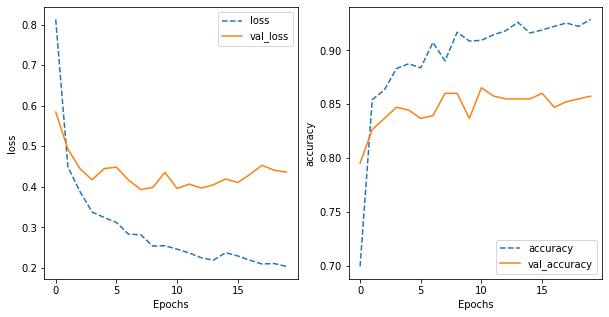

In [5]:
model = train_and_evaluate()

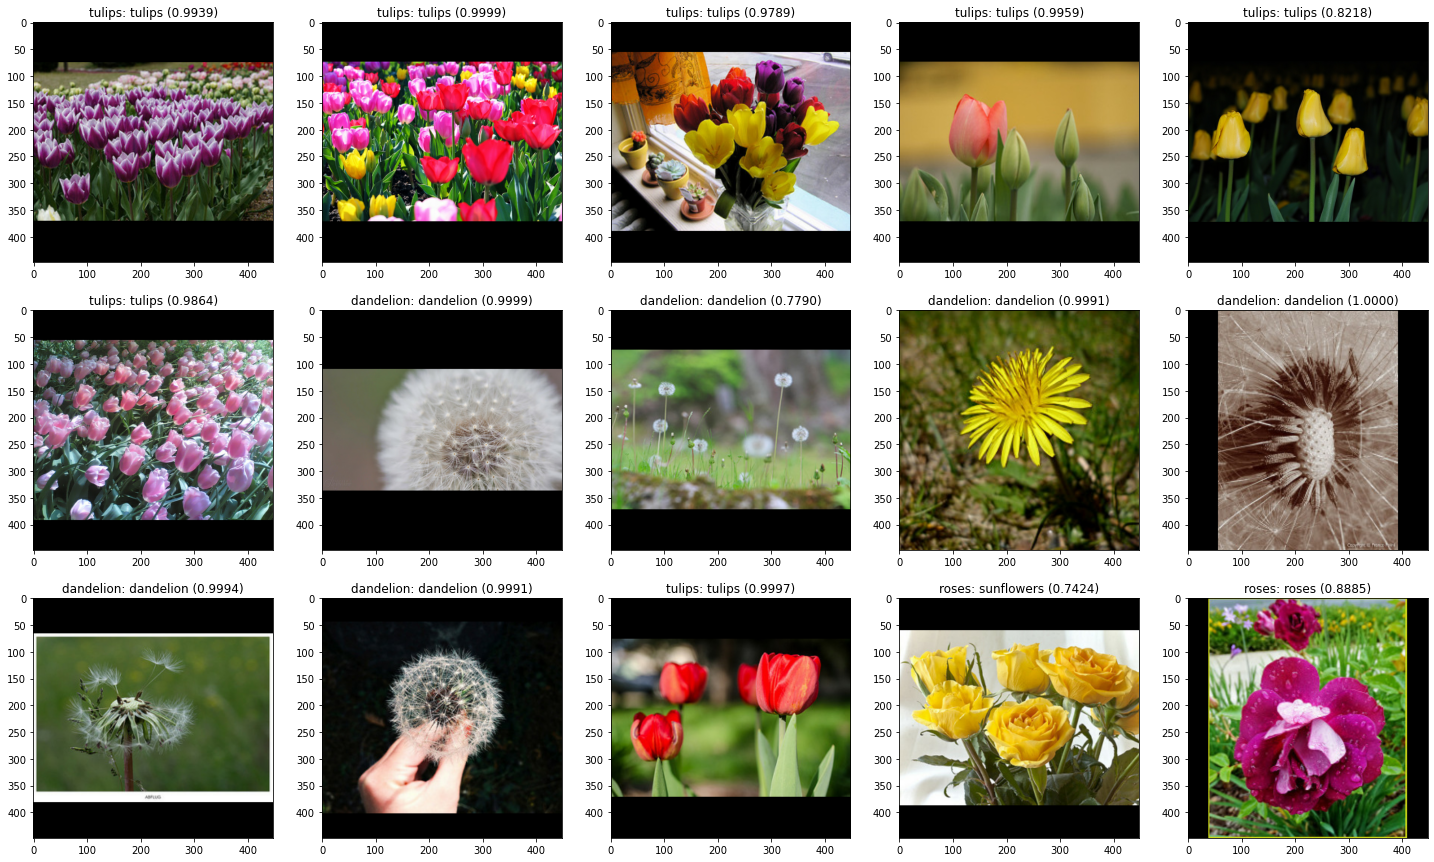

In [6]:
# Call model.predict() on a few images in evaluation dataset
def plot_predictions(model, pattern):
    dataset = create_preproc_dataset(pattern)
    f, ax = plt.subplots(3, 5, figsize=(25,15))
    for idx, (img, label) in enumerate(dataset.take(15)):
        ax[idx//5, idx%5].imshow((img.numpy()));
        batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
        batch_pred = model.predict(batch_image)
        pred = batch_pred[0]
        label = CLASS_NAMES[label.numpy()]
        pred_label_index = tf.math.argmax(pred).numpy()
        pred_label = CLASS_NAMES[pred_label_index]
        prob = pred[pred_label_index]
        ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

plot_predictions(model, 'gs://practical-ml-vision-book/flowers_tfr/valid-*')

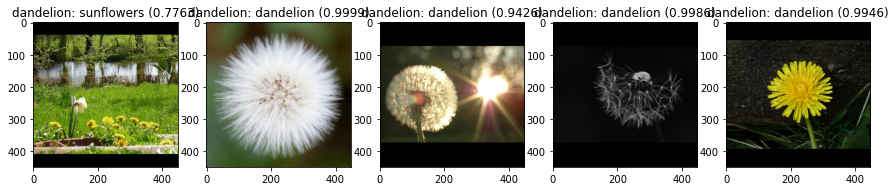

In [7]:
## but actually, for prediction, you won't have TensorFlow Records.
## this is how you'd predict for individual images
filenames = [
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9818247_e2eac18894.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/98992760_53ed1d26a9.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9939430464_5f5861ebab.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9965757055_ff01b5ee6f_n.jpg'
]
label = 'dandelion'
input_images = [create_preproc_image(f) for f in filenames]
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, img in enumerate(input_images):
    ax[idx].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))